# Create figures comparing gridded obs products to stations

Note: this requires raw precipitation time series for all observed data products, which can be downloaded from each products' respective data storage. This also requires the `prtrends*HoAfrica-bypixel-oggrid.nc` files, which are too large to include in a basic storage repository. They can be generated using `calculate_trends_variablelengths.ipynb`. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import xskillscore as xs
import shapely
import os
import re
import glob
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy
import scipy.stats as sstats
from tqdm.notebook import tqdm

from funcs_support import get_filepaths,get_params,utility_print,subset_to_srat,area_mean
from funcs_load import load_raws
from funcs_plot import hist_plot,plot_triangle,plot_triangles
dir_list = get_params()

extra_fonts = {'lato':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Regular.ttf'),
 'lato-bold':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Bold.ttf')}

In [2]:
crit_values = pd.read_csv(dir_list['aux']+'pearsons_r_critical_values.tsv',sep='\t')

seas = 'MAM'

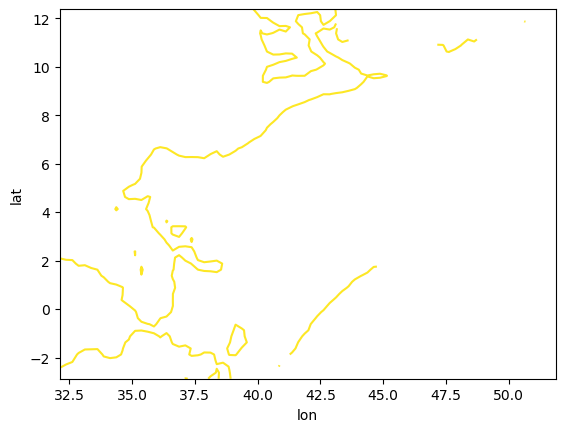

In [3]:
srat = xr.open_dataset(dir_list['aux']+'pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20141231_HoAfrica.nc').seas_ratio
# Create simplified Polygon of double-peaked region
srat_reg = srat.plot.contour(levels=[1])
srat_reg = shapely.geometry.Polygon(np.vstack([srat_reg.allsegs[0][2],srat_reg.allsegs[0][5],
           np.array([[55,12.5],[55,-3]])]))

In [4]:
# Load station trends
dss = load_raws({'varname':'prtrends','exp':'stations'},
                force_load = True,source_dir = 'proc',
                subset_params = {'start_year':slice(1958,2023),
                                 'end_year':slice(1958,2023),
                                 'season':'MAM'})
if 'NIC131hom' in dss:
    del dss['NIC131hom']

# GHCN was saved in a slightly differnt format, with a reserved
# name as a dimension
dss['GHCN'] = dss['GHCN'].rename({'id':'station'})

# load_raws is adding singleton run dimension, sigh
for smod in dss:
    dss[smod] = dss[smod].isel(run=0,drop=True)

In [5]:
## Load values manually, not through load_raws, to avoid 
## loading into memory (some of these by pixel trend files are 
## 75GB)

seas = 'MAM'
var_list = ['prtrend','pr_tsslope']

# Get filepaths of by pixel trend files (should also probably
# do this by the regridded grid)
df = get_filepaths(source_dir = 'proc')
df = df.query('varname == "prtrends" and suffix == "HoAfrica-bypixel-oggrid"')

dss_grid = dict()
for row,row_idx in zip(df.iterrows(),range(len(df))):
    # Load metadata without loading into memory
    ds = xr.open_dataset(row[1]['path'])
    # Subset to variables, season needed
    ds = ds[var_list].sel(season=seas)

    # Get closest grid cell to each station
    ds = {smod:ds.interp(lat=dss[smod].lat,
                           lon=dss[smod].lon,
                          method='nearest')
              for smod in dss}

    dss_grid[row[1]['model']] = ds
    del ds
    
    print(row[1]['model']+' processed')

CHIRPS processed
GPCP processed
CHIRPSv3 processed
CRU-TS processed
GPCC-monitoring processed
GPCC-full processed
UDel processed
CMORPH processed
CMAP processed
TerraClimate processed
CenTrends processed


In [6]:
# Concatenate into single datasets
dss_grid = {smod:xr.concat([ds[smod] for mod,ds in dss_grid.items()],
                          dim = pd.Index([mod for mod in dss_grid],name='model'))
             for smod in dss}

In [7]:
# Add trend_length back in
for smod in dss_grid:
    dss_grid[smod]['trend_length'] = dss_grid[smod]['end_year'] - dss_grid[smod]['start_year']
    dss_grid[smod]['trend_length'] = dss_grid[smod]['trend_length'].where(dss_grid[smod]['trend_length']>0)

## Calculate trend correlations

In [8]:
nbruns = 50 # number of bootstrap runs
bthresh = 0.95 # fraction of total sample to subset each time

corrs = dict()
srat_idxs = dict()

In [9]:
for smod in dss:
    corrs[smod] = dict()

    #---------- Geographically constrain to double-peaked region ----------
    # Get geodataframe of all the points / station locations
    gdf = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(x,y) 
     for x,y in zip(dss[smod].lon,dss[smod].lat)])
    
    # Get geodataframe of the polygon of the (simplified) double-peaked region
    gdf_reg = gpd.GeoDataFrame(geometry=[srat_reg])
    
    # Get idxs of pixels that are within the double-peaked region
    srat_idxs[smod] = gpd.sjoin(gdf, gdf_reg, how='inner', predicate='within').index.values
    
    for trend_length in tqdm([tl for tl in np.unique(dss_grid[smod].trend_length) if ~np.isnan(tl)]):
        
        # Get gridded, station data subset by a specific trend length
        an_data_all = [dss[smod].isel(station=srat_idxs[smod]).where(dss[smod].trend_length == trend_length),
                       dss_grid[smod].isel(station=srat_idxs[smod]).where(dss_grid[smod].trend_length == trend_length)]
        
        # Match up order and selection of start/end years and station
        an_data_all = [ad.sel({dim:[v in an_data_all[int(not bool(ad_idx))][dim] 
                                     for v in an_data_all[int(bool(ad_idx))][dim].values]
                                for dim in ['start_year','end_year','station']})
                        for ad,ad_idx in zip(an_data_all,range(len(an_data_all)))]
        
        # Transpose 
        an_data_all = [ad.transpose(*['start_year','end_year','station',
                                      *[dim for dim in ad.sizes if dim not in ['start_year','end_year','station']]])
                       for ad in an_data_all]
        
        # Stack 
        an_data_all = [ad.stack(allv = ['start_year','end_year','station'])
                       for ad in an_data_all]
    
        # Get which idxs are not nan in both gridded and station
        nonan_idxs = (~np.isnan(an_data_all[0][var_list]) &
                          ~np.isnan(an_data_all[1][var_list]))
    
        # Process by variable
        corrs[smod][trend_length] = dict()
        for var in var_list:
            corrs[smod][trend_length][var] = dict()
    
            # Process by gridded product
            for mod in an_data_all[1]['model'].values:
                # Subset to individual gridded product, needed because 
                # location of non-nans is different between models
                an_data_tmp = [an_data_all[0],
                               an_data_all[1].sel(model=mod)]
                # Drop nans to allow for bootstrap subsetting
                an_data_tmp = [ad[var].isel(allv = nonan_idxs[var].sel(model=mod).values) for ad in an_data_tmp]
            
                # Get bootstrap run idxs 
                b_idxs = xr.DataArray(data = np.random.randint(0,nonan_idxs[var].sel(model=mod).sum(),
                                      size = (int(nonan_idxs[var].sel(model=mod).sum()*bthresh), 
                                          nbruns)),
                                       dims = ['allv','brun'])
                
                # Create bootstap runs 
                an_data_tmp = [ad.isel(allv=b_idxs) for ad in an_data_tmp]
            
                # Calculate corrs
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    corrs[smod][trend_length][var][mod] = xr.merge([xr.corr(*an_data_tmp,dim='allv').to_dataset(name=var+'_corr'),
                                                               xs.pearson_r_p_value(*an_data_tmp,dim='allv').to_dataset(name=var+'_p')])
                    # Add year range used to perform correlations, for reference
                    if len(an_data_tmp[0]['start_year'])>0:
                        corrs[smod][trend_length][var][mod]['year_range'] = (['bnd'],[an_data_tmp[0].start_year.min(),
                                                                                      an_data_tmp[0].end_year.max()])
                    else:
                        corrs[smod][trend_length][var][mod]['year_range'] = (['bnd'],[np.nan,np.nan])
            
            # Collate into single ds
            corrs[smod][trend_length][var] = xr.concat([c for mod,c in corrs[smod][trend_length][var].items()],
                                                    dim = pd.Index([mod for mod in corrs[smod][trend_length][var]],name='model'))
            # Add number of samples used to calculate correlation
            corrs[smod][trend_length][var][var+'_nsamples'] = nonan_idxs.sum('allv')[var]
        
        # Collate into single ds
        # compat=override is for the year_range variable, which is identical for both variables,
        # this way just one of them is merged 
        corrs[smod][trend_length] = xr.merge([ds for var,ds in corrs[smod][trend_length].items()],
                                             compat='override')


  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

In [10]:
# Collate into single ds
corrs = xr.concat([xr.concat([ds for tl,ds in corr.items()],
              dim=pd.Index([tl for tl in corr],name='trend_length'))
               for smod,corr in corrs.items()],
              dim=pd.Index([smod for smod in corrs],name='smod'))

In [11]:
# Drop CHIRPSv3 
corrs = corrs.sel(model=[mod for mod in corrs.model.values if mod != 'CHIRPSv3'])

## Figure

/home/kschwarz/projects/future_stability/figures/figureS3.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS3.png saved!


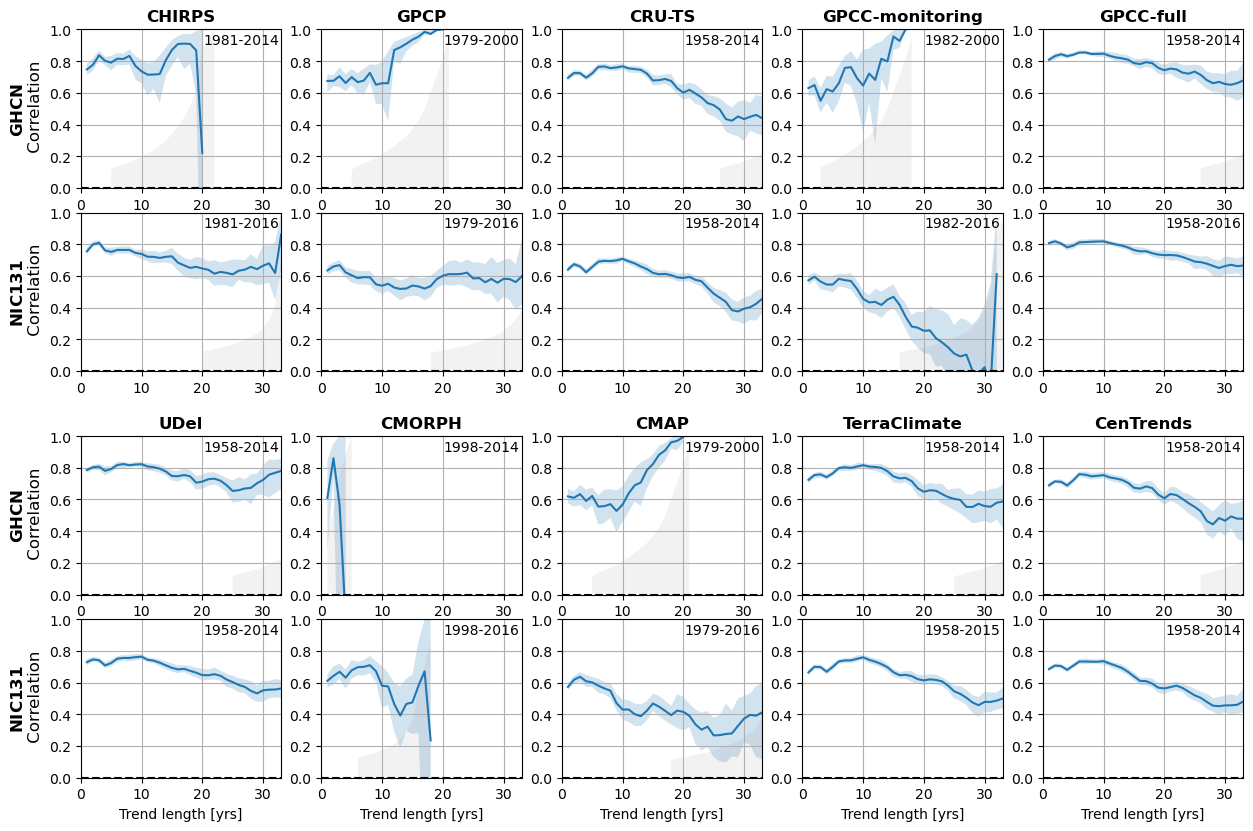

In [12]:
var = 'prtrend'

save_fig = True
#output_fn = dir_list['figs']+'stns_test_corrsvsgrid'
output_fn = dir_list['figs']+'figureS3'

#smods = [corrs.smod.values]
#smods = ['NIC131','NIC131hom']
smods = ['GHCN','NIC131']

# Annotation of year range available for trends > this number
trend_years_lim = 4


ncol = 5
n_smod = len(smods)

nrows = (corrs.sizes['model'] // ncol + 1) * n_smod 
nrows = nrows + int((nrows / n_smod) - 1)

crit_values_tmp = crit_values.set_index('N').to_xarray()['0.05'].interp(N = corrs[var+'_nsamples'],
                                                                        method='linear')

# Get ratios of subplot height, for formatting
height_ratios = np.ones(nrows)
height_ratios[np.arange(0,nrows)[n_smod::(n_smod+1)]] = 0.1

#fig = plt.figure(figsize=(15,12))
fig,axs = plt.subplots(nrows,
                       ncol,
                       figsize=(15,15),
                       gridspec_kw={'height_ratios':height_ratios}
                        )


for smod_idx,smod in zip(np.arange(0,n_smod),smods):
    #---------- Plot ----------    
    for mod_idx,mod in zip(np.arange(0,corrs.sizes['model']),corrs.model.values):
        
        #--------- Plot location ---------
        # Get row index
        row_idx = (mod_idx // ncol)*n_smod + smod_idx
        # Add offset for dummy axis in the middle 
        row_idx = row_idx + mod_idx // ncol

        # Column index
        col_idx = mod_idx % ncol
        
        #--------- Plot ---------
        # Get data to plot
        plot_data = corrs.sel(model=mod,smod=smod)[var+'_corr']

        # Plot mean correlation
        plot_data.mean('brun').plot(ax=axs[row_idx,col_idx])
        # Plot bootstrap range
        with warnings.catch_warnings():
            # Ignores all-NaNslice warning
            warnings.filterwarnings('ignore')
            # Plot bootstrap CIs
            axs[row_idx,col_idx].fill_between(plot_data.trend_length,
                                              plot_data.quantile(0.05,dim='brun'),
                                              plot_data.quantile(0.95,dim='brun'),
                                              alpha = 0.2)
            
        # Plot significance barrier
        axs[row_idx,col_idx].fill_between(plot_data.trend_length,
                                          plot_data.trend_length*0,
                                          crit_values_tmp.sel(model=mod,smod=smod),
                                          facecolor='grey',
                                          alpha=0.1)
        
        #--------- Annotations ---------
        # List year range used for trends > x years
        axs[row_idx,col_idx].annotate('-'.join([str(int(y)) for y in [corrs.sel(smod=smod,model=mod,trend_length=slice(trend_years_lim,None)).year_range.isel(bnd=0).min().values,
                                        corrs.sel(smod=smod,model=mod,trend_length=slice(trend_years_lim,None)).year_range.isel(bnd=1).max().values]]),
                    (0.99,0.975),va='top',ha='right',xycoords='axes fraction')
        
        if smod_idx == 0:
            axs[row_idx,col_idx].set_title(mod,fontsize=12,fontweight='bold')
        else:
            axs[row_idx,col_idx].set_title('')
            
        if (mod_idx % ncol) == 0:
            axs[row_idx,col_idx].set_ylabel(r'$\mathbf{'+smod+'}$'+'\n Correlation',fontsize=12)
        else:
            axs[row_idx,col_idx].set_ylabel('')
            
        if (smod_idx == (n_smod-1)) and ((row_idx == (nrows - 1)) or 
                                         ((row_idx == (nrows - n_smod - 2)) and (col_idx >= (corrs.sizes['model'] % ncol)))):
            axs[row_idx,col_idx].set_xlabel('Trend length [yrs]')
        else:
            axs[row_idx,col_idx].set_xlabel('')
            
        axs[row_idx,col_idx].axhline(0,color='k',linestyle='--')
        axs[row_idx,col_idx].grid()

        axs[row_idx,col_idx].set_ylim(0,1)
        axs[row_idx,col_idx].set_xlim(0,33)
        
#--------- Plot Annotations ---------
# Blank out rows
blank_rows = ((n_smod+1) * np.arange(0,corrs.sizes['model'] // ncol + 1) - 1)[1:]
for row_idx in blank_rows: 
    for col_idx in np.arange(0,ncol):
        axs[row_idx,col_idx].set_visible(False)
        
# Blank out panels in rows at the end 
for col_idx in np.arange(corrs.sizes['model'] % ncol, ncol):
    for row_idx in np.arange((len(axs)-n_smod),len(axs)):
        axs[row_idx,col_idx].set_visible(False)


if save_fig:
    utility_print(output_fn)